In [1]:
import os
import shutil

ROOT_DIR = '/content/drive/MyDrive/img'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'brain_tumor')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')

In [6]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'brain_tumor.zip'), 'r') as target_file:
  target_file.extractall(DATA_ROOT_DIR)

In [7]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:
  test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  test_file_list = os.listdir(test_path)
  train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  
  moved_num = 0
  for test_image_file in test_file_list:
    shutil.move(os.path.join(test_path, test_image_file),
                os.path.join(train_path, test_image_file))  
    moved_num += 1

  print(str(moved_num) + ' is moved into ' + label_name + ' (Testing => Training)')

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
100 is moved into glioma_tumor (Testing => Training
115 is moved into meningioma_tumor (Testing => Training
105 is moved into no_tumor (Testing => Training
74 is moved into pituitary_tumor (Testing => Training


In [8]:
import random

MOVE_RATIO = 0.2 # train : test = 80 : 20, 즉 train 데이터의 20% 데이터를 test 데이터로 사용

# 파일 move train_data_dir => test_data_dir
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
  # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
  # =========================================================
  src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  # =========================================================

  train_data_file_list = os.listdir(src_dir_path)
  random.shuffle(train_data_file_list)
  split_num = int(MOVE_RATIO * len(train_data_file_list))
  test_data_file_list = train_data_file_list[0:split_num]

  for test_data_file in test_data_file_list:
    try:
      shutil.move(os.path.join(src_dir_path, test_data_file),
                  os.path.join(dst_dir_path, test_data_file))
    except Exception as err:
      print(str(err))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                    color_mode='rgb', class_mode='sparse',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT))
test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32,
                                                    color_mode='rgb', class_mode='sparse',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT))

print(train_generator.class_indices)
print(train_generator.num_classes)

Found 2529 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet

class_nums = train_generator.num_classes # 정답개수

pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

17225924/17225924 [==============================] - 1s 0us/step


In [4]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=[earlystopping])

Epoch 1/50
80/80 [==============================] - 989s 12s/step - loss: 1.7754 - acc: 0.3321 - val_loss: 1.1358 - val_acc: 0.5388
Epoch 2/50
80/80 [==============================] - 20s 251ms/step - loss: 1.1633 - acc: 0.5164 - val_loss: 0.9382 - val_acc: 0.6466
Epoch 3/50
80/80 [==============================] - 21s 262ms/step - loss: 0.9229 - acc: 0.6164 - val_loss: 0.8034 - val_acc: 0.6910
Epoch 4/50
80/80 [==============================] - 22s 272ms/step - loss: 0.7749 - acc: 0.6991 - val_loss: 0.6785 - val_acc: 0.7639
Epoch 5/50
80/80 [==============================] - 22s 275ms/step - loss: 0.6782 - acc: 0.7422 - val_loss: 0.5602 - val_acc: 0.8162
Epoch 6/50
80/80 [==============================] - 21s 263ms/step - loss: 0.5934 - acc: 0.7798 - val_loss: 0.5078 - val_acc: 0.8241
Epoch 7/50
80/80 [==============================] - 20s 250ms/step - loss: 0.4990 - acc: 0.8221 - val_loss: 0.4414 - val_acc: 0.8463
Epoch 8/50
80/80 [==============================] - 21s 262ms/step - l

In [5]:
model.evaluate(test_generator)

20/20 [==============================] - 4s 192ms/step - loss: 0.2144 - acc: 0.9414


[0.21436090767383575, 0.9413629174232483]

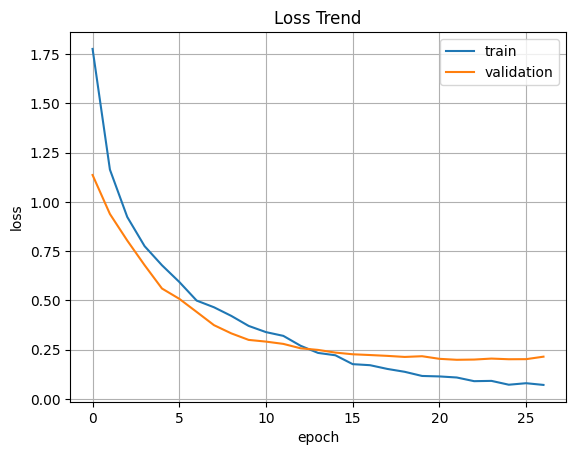

In [6]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.grid()
plt.show()

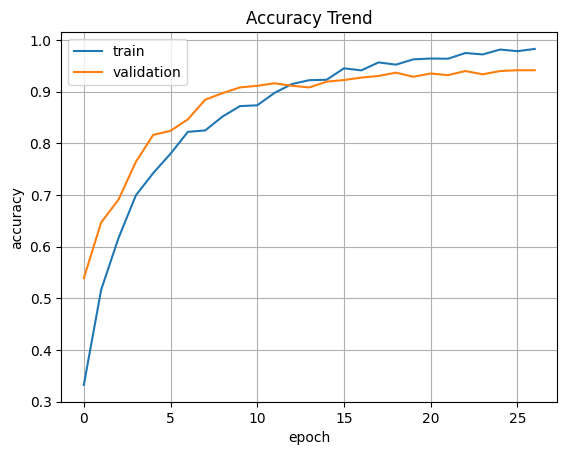

In [7]:
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.legend(loc='best')
plt.grid()
plt.show()